In [66]:
import soundfile as sf
import librosa
import os

In [102]:
# Import the data to be tested
audio_file = '/Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/ChildrenAudio/M21_09_08.wav'
audio_signal, fs = sf.read(audio_file)

# Filter A Design

In [84]:
import numpy as np
from scipy.signal import butter, lfilter, sosfilt, sosfreqz
import matplotlib.pyplot as plt

In [120]:
def design_bandpass_filter(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    if low <= 0 or high >= 1 or low >= high:
        raise ValueError(f"Invalid bandpass frequencies: lowcut={lowcut}, highcut={highcut}, fs={fs}")
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

In [121]:
def create_filter_bank(fs, num_channels=16, low_freq=100, high_freq=8000, order=4):
    nyquist = 0.5 * fs
    if high_freq > nyquist:
        raise ValueError(f"high_freq must be <= Nyquist frequency ({nyquist} Hz)")
    center_freqs = np.logspace(np.log10(low_freq), np.log10(high_freq), num_channels)
    filters = []
    for i in range(num_channels):
        if i == 0:
            lowcut = low_freq
        else:
            lowcut = center_freqs[i-1] * 2**(-1/2)
        if i == num_channels - 1:
            highcut = high_freq
        else:
            highcut = center_freqs[i] * 2**(1/2)
        # Ensure lowcut and highcut are within valid range
        lowcut = max(lowcut, 0.01)  # Set a minimum lowcut frequency
        highcut = min(highcut, nyquist - 0.01)  # Set a maximum highcut frequency
        sos = design_bandpass_filter(lowcut, highcut, fs, order)
        filters.append(sos)
    return filters, center_freqs

In [122]:
def apply_filter_bank(audio_signal, fs, filters):
    filtered_signals = []
    for sos in filters:
        filtered = sosfilt(sos, audio_signal)
        filtered_signals.append(filtered)
    return filtered_signals

In [123]:
def envelope_detection(filtered_signals, fs, cutoff=400, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    sos = butter(order, normal_cutoff, btype='low', output='sos')
    envelopes = []
    for signal in filtered_signals:
        rectified = np.abs(signal)
        envelope = sosfilt(sos, rectified)
        envelopes.append(envelope)
    return envelopes


In [124]:
def combine_envelopes(envelopes):
    combined_signal = np.sum(envelopes, axis=0)
    return combined_signal

In [125]:
# Create filter bank
filters, center_freqs = create_filter_bank(fs)

# Apply filter bank
filtered_signals = apply_filter_bank(audio_signal, fs, filters)

# Envelope detection
envelopes = envelope_detection(filtered_signals, fs)

# Combine envelopes
processed_signal = combine_envelopes(envelopes)

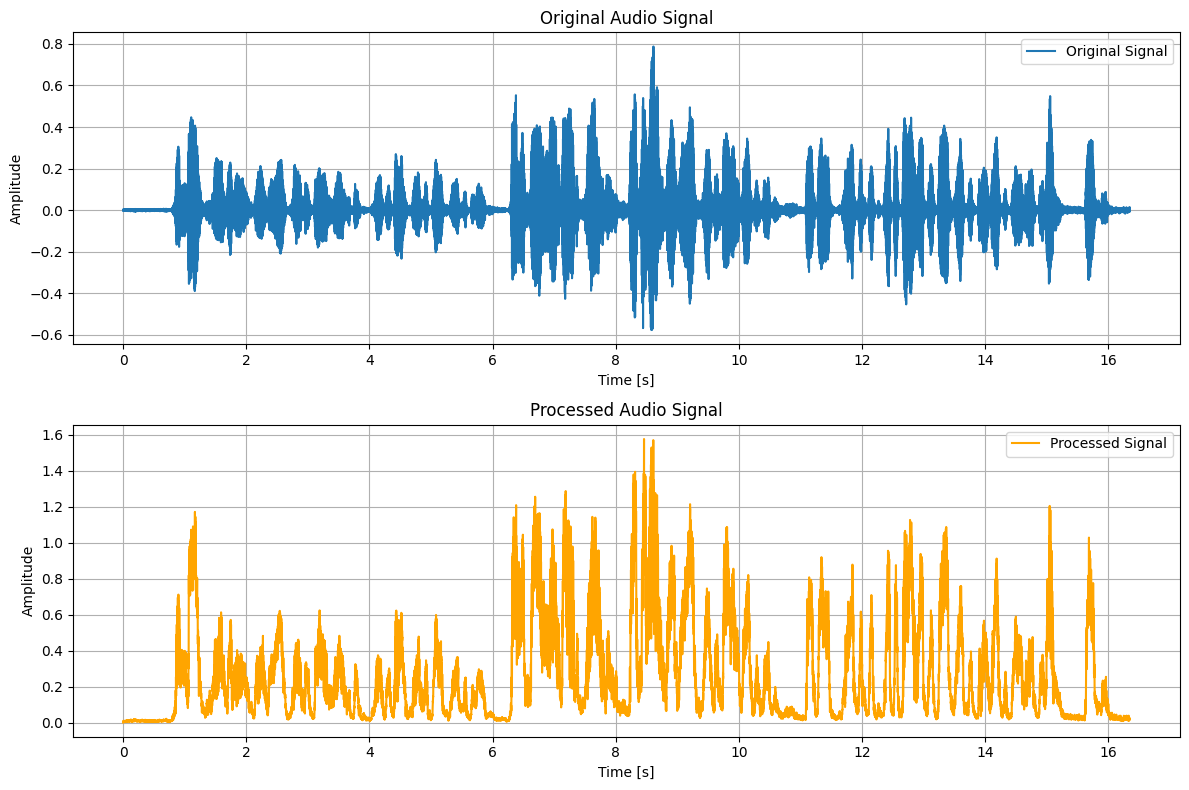

In [133]:
# Plot the original and processed signals
time = np.arange(len(audio_signal)) / fs

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, audio_signal, label='Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original Audio Signal')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, processed_signal, label='Processed Signal', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Processed Audio Signal')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [127]:
def plot_sound_waveform(audio_file):
    try:
        # Load the audio file
        y, sr = librosa.load(audio_file, sr=None)  # sr=None preserves the original sample rate
        
        # Create the time array
        time = np.arange(0, len(y)) / sr
        
        # Plot the waveform
        plt.figure(figsize=(12, 4))
        plt.plot(time, y)
        plt.title(f'Sound Waveform: {os.path.basename(audio_file)}')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {audio_file}: {str(e)}")

In [130]:
# Save the filtered audio
output_filename = '/Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/results/ChildrenAudio/M21_09_08.wav'
sf.write(output_filename, processed_signal, fs)

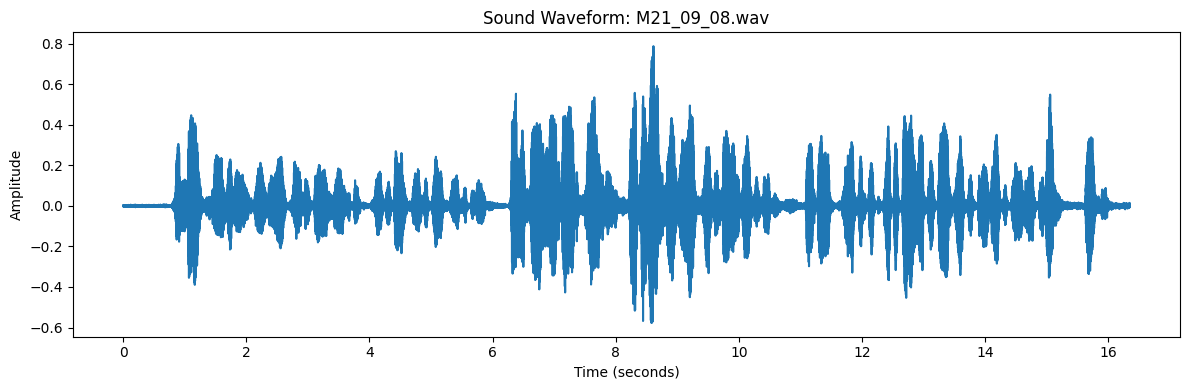

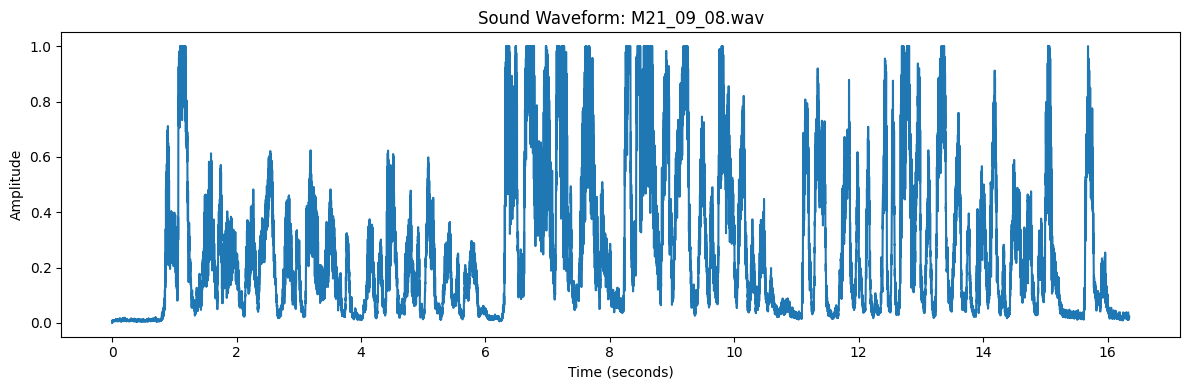

In [132]:
plot_sound_waveform(audio_file)
plot_sound_waveform(output_filename)


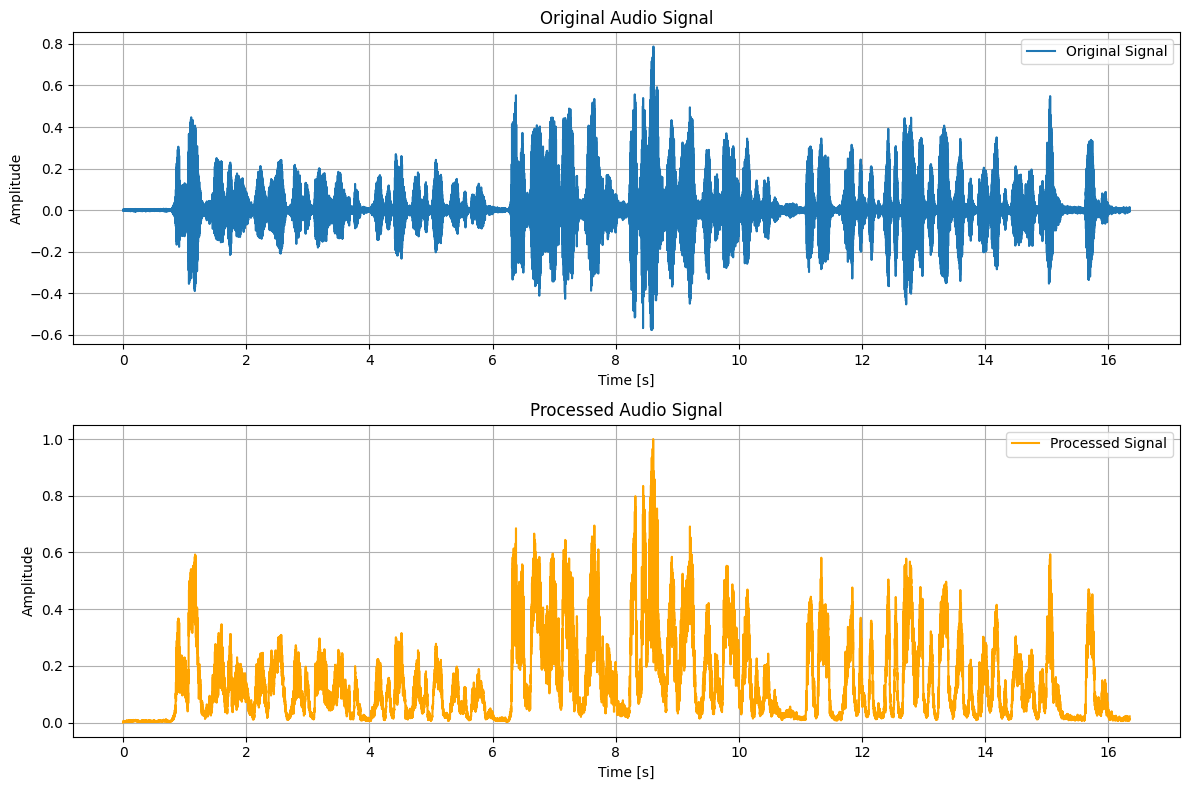

In [136]:
import numpy as np
from scipy.signal import firwin, sosfilt, butter
import soundfile as sf
import matplotlib.pyplot as plt

def design_fir_bandpass_filter(lowcut, highcut, fs, numtaps=101):
    nyquist = 0.5 * fs
    taps = firwin(numtaps, [lowcut / nyquist, highcut / nyquist], pass_zero=False)
    return taps

def create_filter_bank(fs, num_channels=22, low_freq=100, high_freq=8000, numtaps=101):
    nyquist = 0.5 * fs
    if high_freq > nyquist:
        raise ValueError(f"high_freq must be <= Nyquist frequency ({nyquist} Hz)")
    center_freqs = np.logspace(np.log10(low_freq), np.log10(high_freq), num_channels)
    filters = []
    for i in range(num_channels):
        if i == 0:
            lowcut = low_freq
        else:
            lowcut = center_freqs[i-1] * 2**(-1/2)
        if i == num_channels - 1:
            highcut = high_freq
        else:
            highcut = center_freqs[i] * 2**(1/2)
        # Ensure lowcut and highcut are within valid range
        lowcut = max(lowcut, 0.01)  # Set a minimum lowcut frequency
        highcut = min(highcut, nyquist - 0.01)  # Set a maximum highcut frequency
        taps = design_fir_bandpass_filter(lowcut, highcut, fs, numtaps)
        filters.append(taps)
    return filters, center_freqs

def apply_filter_bank(audio_signal, fs, filters):
    filtered_signals = []
    for taps in filters:
        filtered = np.convolve(audio_signal, taps, mode='same')
        filtered_signals.append(filtered)
    return filtered_signals

def envelope_detection(filtered_signals, fs, cutoff=300, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    sos = butter(order, normal_cutoff, btype='low', output='sos')
    envelopes = []
    for signal in filtered_signals:
        rectified = np.abs(signal)
        envelope = sosfilt(sos, rectified)
        envelopes.append(envelope)
    return envelopes

def combine_envelopes(envelopes):
    combined_signal = np.sum(envelopes, axis=0)
    return combined_signal

# Load the audio file
audio_file = '/Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/ChildrenAudio/M21_09_08.wav'
audio_signal, fs = sf.read(audio_file)

# Ensure audio_signal is mono
if audio_signal.ndim > 1:
    audio_signal = np.mean(audio_signal, axis=1)

# Create filter bank
filters, center_freqs = create_filter_bank(fs)

# Apply filter bank
filtered_signals = apply_filter_bank(audio_signal, fs, filters)

# Envelope detection
envelopes = envelope_detection(filtered_signals, fs)

# Combine envelopes
processed_signal = combine_envelopes(envelopes)

# Normalize the processed signal
processed_signal /= np.max(np.abs(processed_signal))

# Plot the original and processed signals
time = np.arange(len(audio_signal)) / fs

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, audio_signal, label='Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original Audio Signal')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, processed_signal, label='Processed Signal', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Processed Audio Signal')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [138]:
output_filename = '/Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/results/ChildrenAudio/M21_09_08-v2.wav'
sf.write(output_filename, processed_signal, fs)

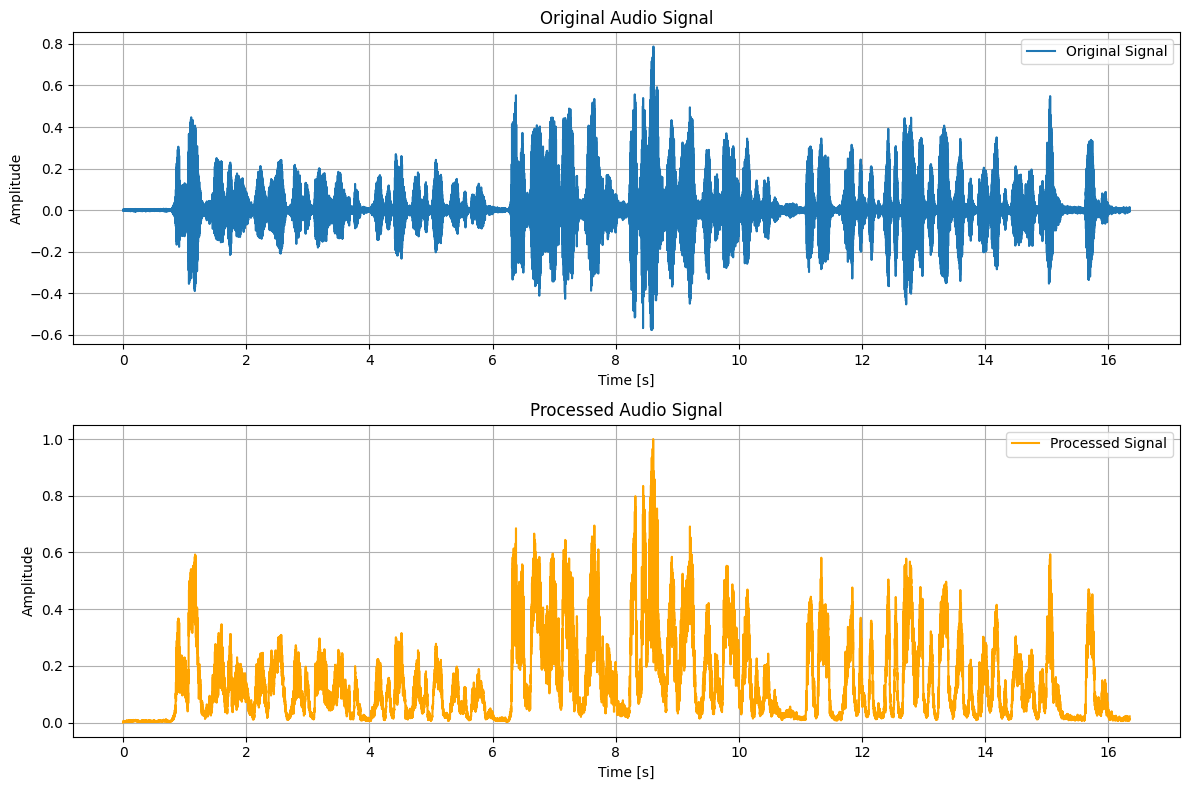

In [141]:
import numpy as np
from scipy.signal import firwin, sosfilt, butter
import soundfile as sf
import matplotlib.pyplot as plt

def design_fir_bandpass_filter(lowcut, highcut, fs, numtaps=101):
    nyquist = 0.5 * fs
    taps = firwin(numtaps, [lowcut / nyquist, highcut / nyquist], pass_zero=False)
    return taps

def create_filter_bank(fs, num_channels=22, low_freq=100, high_freq=8000, numtaps=101):
    nyquist = 0.5 * fs
    if high_freq > nyquist:
        raise ValueError(f"high_freq must be <= Nyquist frequency ({nyquist} Hz)")
    center_freqs = np.logspace(np.log10(low_freq), np.log10(high_freq), num_channels)
    filters = []
    for i in range(num_channels):
        if i == 0:
            lowcut = low_freq
        else:
            lowcut = center_freqs[i-1] * 2**(-1/2)
        if i == num_channels - 1:
            highcut = high_freq
        else:
            highcut = center_freqs[i] * 2**(1/2)
        # Ensure lowcut and highcut are within valid range
        lowcut = max(lowcut, 0.01)  # Set a minimum lowcut frequency
        highcut = min(highcut, nyquist - 0.01)  # Set a maximum highcut frequency
        taps = design_fir_bandpass_filter(lowcut, highcut, fs, numtaps)
        filters.append(taps)
    return filters, center_freqs

def apply_filter_bank(audio_signal, fs, filters):
    filtered_signals = []
    for taps in filters:
        filtered = np.convolve(audio_signal, taps, mode='same')
        filtered_signals.append(filtered)
    return filtered_signals

def envelope_detection(filtered_signals, fs, cutoff=300, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    sos = butter(order, normal_cutoff, btype='low', output='sos')
    envelopes = []
    for signal in filtered_signals:
        rectified = np.abs(signal)
        envelope = sosfilt(sos, rectified)
        envelopes.append(envelope)
    return envelopes

def combine_envelopes(envelopes):
    combined_signal = np.sum(envelopes, axis=0)
    return combined_signal

# Load the audio file
audio_file = '/Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/data/cleaned_dataset/ChildrenAudio/M21_09_08.wav'
audio_signal, fs = sf.read(audio_file)

# Ensure audio_signal is mono
if audio_signal.ndim > 1:
    audio_signal = np.mean(audio_signal, axis=1)

# Create filter bank
filters, center_freqs = create_filter_bank(fs)

# Apply filter bank
filtered_signals = apply_filter_bank(audio_signal, fs, filters)

# Envelope detection
envelopes = envelope_detection(filtered_signals, fs)

# Combine envelopes
processed_signal = combine_envelopes(envelopes)

# Normalize the processed signal
processed_signal /= np.max(np.abs(processed_signal))

# Plot the original and processed signals
time = np.arange(len(audio_signal)) / fs

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, audio_signal, label='Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original Audio Signal')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, processed_signal, label='Processed Signal', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Processed Audio Signal')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [142]:
output_filename = '/Users/alexszabo/MTE/2B/MTE252/Projects/MTE252-P01/results/ChildrenAudio/M21_09_08-v3.wav'
sf.write(output_filename, processed_signal, fs)